In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score

In [2]:
 warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('univariate_T10.csv')

In [4]:
data_temp=df.values
print(np.shape(data_temp))
print(sum(df.LABEL == True))#导入数据

(2234, 53)
340


In [5]:
from sklearn.model_selection import train_test_split

X, y = data_temp[:, 1:], data_temp[:, 0]

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)#划分训练集
sum(y_test)#测试集里多少个萧条样本

102.0

In [6]:
sum(y_train)#训练集里多少个萧条样本

238.0

In [7]:
sum(y_test)#测试集里多少个萧条样本

102.0

In [8]:
# upsampling
print('Number of recession samples before:',X_train[y_train==1].shape[0])
print('Number of normal samples before:',X_train[y_train==0].shape[0])
X_upsampled, y_upsampled = resample(X_train[y_train==1], y_train[y_train==1],
                                   replace=True,
                                   n_samples = X_train[y_train==0].shape[0],
                                   random_state = 1)
print("Number of recession samples after:", X_upsampled.shape[0])

Number of recession samples before: 238
Number of normal samples before: 1325
Number of recession samples after: 1325


In [9]:
X_train_bal = np.vstack((X_train[y_train==0], X_upsampled))

In [10]:
y_train_bal = np.hstack((y_train[y_train==0], y_upsampled))

In [11]:
print(X_train_bal.shape)
print(y_train_bal.shape)

(2650, 52)
(2650,)


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [13]:
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train_bal)
X_test_std = stdsc.transform(X_test)#标准化

In [14]:
##LR
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=3),
                        LogisticRegression(random_state=1))

In [15]:
scores = cross_val_score(estimator = pipe_lr,
                        X=X_train_bal,
                        y=y_train_bal,
                        cv=10,
                        scoring='f1',
                        n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.80784314 0.84981685 0.80620155 0.79104478 0.81954887 0.76086957
 0.79847909 0.8057554  0.80620155 0.81343284]
CV accuracy: 0.806 +/- 0.021


In [16]:
lr = LogisticRegression(penalty='l2')
lr.fit(X_train_std, y_train_bal)
y_pred_lr2 = lr.predict(X_test_std)

In [17]:
lr.coef_

array([[-0.27915338, -0.1906059 , -0.09413267, -0.25146385, -1.3810157 ,
         0.31732893, -0.70575115, -0.40289937,  0.57724825,  0.24391575,
        -0.01871224,  0.486869  , -0.41368064, -0.90802274, -0.55249437,
         0.03658965,  0.09714783,  0.1175267 , -0.73729656,  1.36870836,
        -0.42010712,  0.85718812,  0.71370926, -0.3278292 ,  0.54895098,
         0.34316834,  0.08982036,  0.54975506, -0.71472382, -0.15411353,
        -0.65355567, -1.05634957, -0.67091286,  0.52334617,  0.43666995,
         0.0478582 , -0.67444692,  0.77868055,  0.59077373,  0.88903864,
         0.32976421, -0.14297349,  0.79087701, -1.43054259, -0.27215564,
         0.30871109,  0.61228755,  0.08247961, -1.57530554,  0.29924679,
        -1.11669509, -0.26287432]])

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred=y_pred_lr2

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

[[446 123]
 [ 11  91]]
Precision: 0.425
Recall: 0.892
F1: 0.576


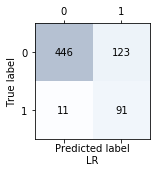

In [19]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label\nLR')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig('Pic/T10/LR', dpi=300)
plt.show()

In [20]:
## Tree pipeline
pipe_tree = make_pipeline(StandardScaler(),
                        #PCA(n_components=3),
                         DecisionTreeClassifier(criterion='gini', max_depth=8, random_state=1))

In [21]:
scores = cross_val_score(estimator = pipe_tree,
                        X=X_train_bal,
                        y=y_train_bal,
                        cv=10,
                        scoring='f1',
                        n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.97435897 0.97080292 0.96727273 0.96727273 0.95683453 0.95306859
 0.97058824 0.96323529 0.96654275 0.95306859]
CV accuracy: 0.964 +/- 0.007


In [22]:
pipe_tree.fit(X_train_bal, y_train_bal)
y_pred_tree = pipe_tree.predict(X_test)
print('Train Accuracy: %.3f' % pipe_tree.score(X_train_bal, y_train_bal))
print('Test Accuracy: %.3f' % pipe_tree.score(X_test, y_test))#忽略该块程序即可，为了可视化tree没用pipeline

Train Accuracy: 0.978
Test Accuracy: 0.928


In [23]:
tree = DecisionTreeClassifier(criterion='gini', 
                              max_depth=10, 
                              random_state=1)
tree.fit(X_train_std, y_train_bal)
y_pred_tree2 = tree.predict(X_test_std)

In [24]:
#tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred=y_pred_tree2

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

[[539  30]
 [ 19  83]]
Precision: 0.735
Recall: 0.814
F1: 0.772


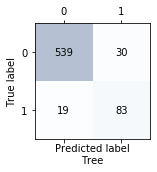

In [25]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label\nTree')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig('Pic/T10/TREE', dpi=300)
plt.show()

In [26]:
import os     
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

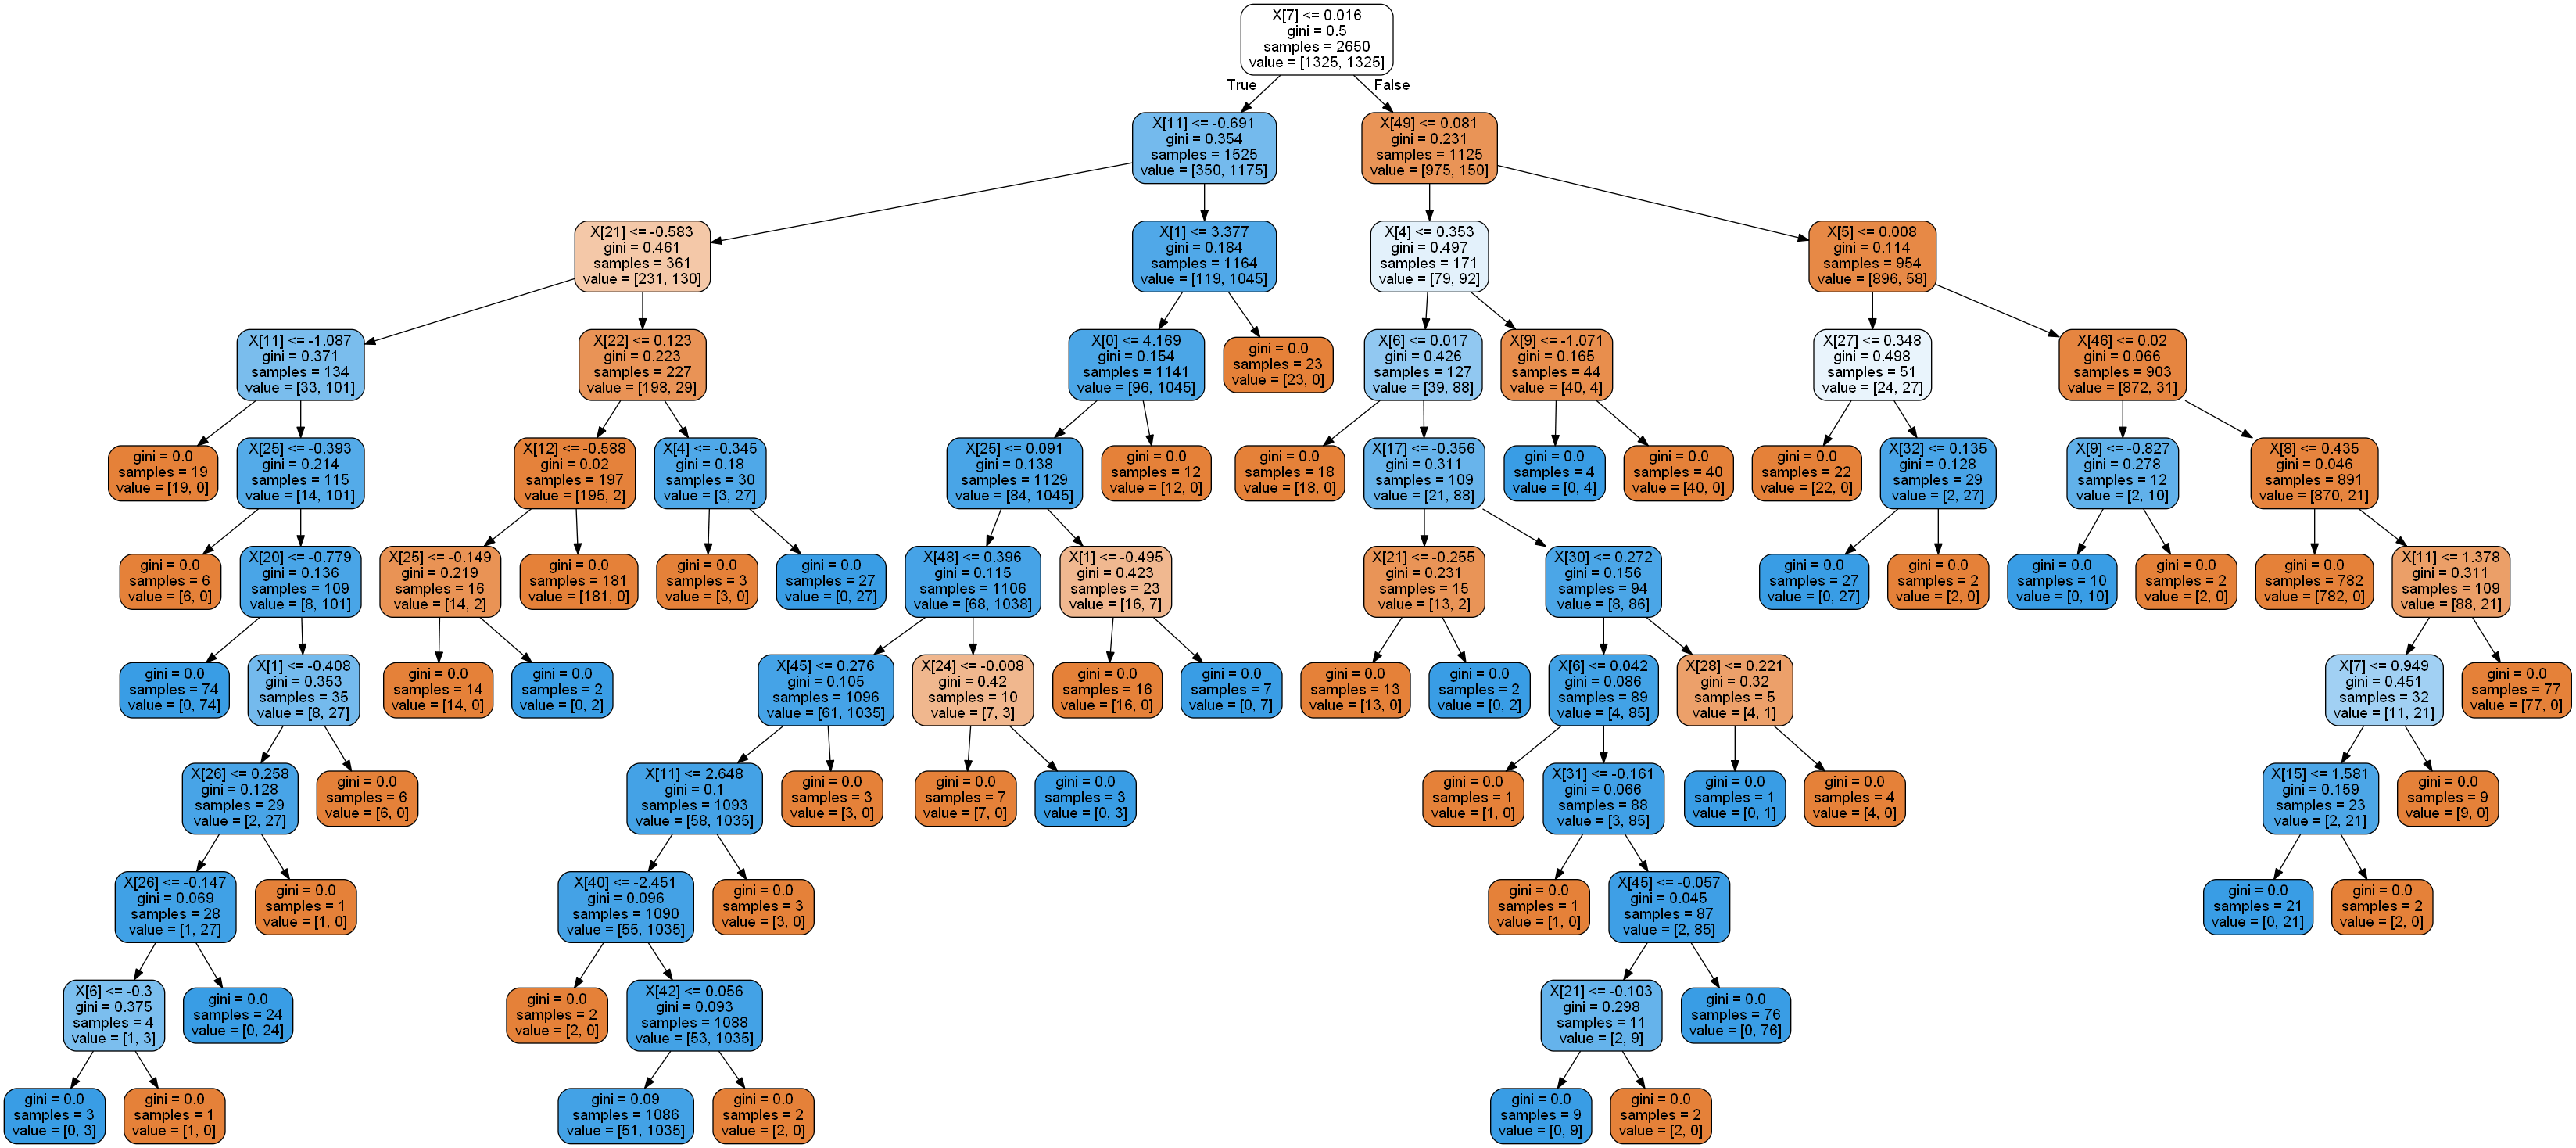

In [27]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree,
                           filled=True, 
                           rounded=True,
                           #class_names=['Setosa', 
                            #            'Versicolor',
                            #            'Virginica'],
                          # feature_names=['petal length', 
                          #                'petal width'],
                           out_file=None) 
graph = graph_from_dot_data(dot_data) 
graph.write_png('Pic/tree_uni10.png') 

from IPython.display import Image
Image(filename='Pic/tree_uni10.png', width=600) 

In [28]:
## SVC pipeline
pipe_svc = make_pipeline(StandardScaler(),
                        PCA(n_components=3),
                         SVC(kernel='rbf',random_state=1,probability=True))

In [29]:
scores = cross_val_score(estimator = pipe_svc,
                        X=X_train_bal,
                        y=y_train_bal,
                        cv=10,
                        scoring='f1',
                        n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.90769231 0.90566038 0.9034749  0.90151515 0.88235294 0.84132841
 0.91472868 0.89377289 0.92307692 0.8778626 ]
CV accuracy: 0.895 +/- 0.022


In [30]:
svm = SVC(kernel='rbf', random_state=1, C=0.01, gamma=0.5) #gamma
svm.fit(X_train_std, y_train_bal)
y_pred_svc2 = svm.predict(X_test_std)

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred=y_pred_svc2

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

[[408 161]
 [  2 100]]
Precision: 0.383
Recall: 0.980
F1: 0.551


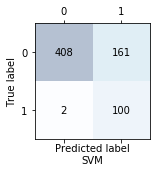

In [32]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label\nSVM')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig('Pic/T10/SVM', dpi=300)
plt.show()

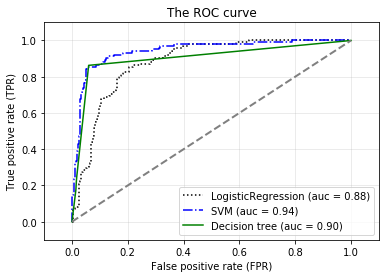

In [33]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
allclf=[pipe_lr,pipe_svc,pipe_tree]
labels=['LogisticRegression','SVM','Decision tree']

colors = ['black' , 'blue', 'green']
linestyles = [':' , '-.', '-']
for clf, label, clr, ls \
        in zip(allclf,
               labels, colors, linestyles):


    probas = clf.fit(X_train_bal,
                     y_train_bal).predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=probas[:, 1],pos_label=1)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

    
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.3)
plt.title('The ROC curve')
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')



plt.savefig('Pic/T10/ROC', dpi=300)
plt.show()

